# Semana 7 - Astrofísica computacional
#### Gabriel Missael Barco 06/03/2020

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import math as mt
import pandas as pd
import cv2
import matplotlib.gridspec as gridspec
import cosmolopy.distance as distance
from scipy.optimize import minimize

### Supernovas
Realizaremos un ejercicio con los datos de la pagina *http://supernovae.in2p3.fr/sdss_snls_jla/ReadMe.html*, referente a supernovas y su corrimiento al rojo. En la siguiente gráfica (obtenida de la misma fuente) se pueden observar los datos a utilizar.

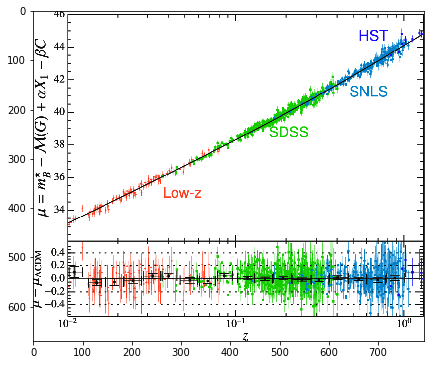

In [17]:
img = cv2.imread("../datos/hubble_diagram.png")
fig, ax = plt.subplots(1, 1, figsize = (7, 7))
plt.imshow(img)

Queremos encontrar $\alpha$ y $\beta$ de la siguiente expresión:

$\mu = m_B* - (M_B - \alpha \times X_1 + \beta \times C) $

In [25]:
datos = pd.read_csv("../datos/Supernova/data/jla_lcparams.txt", sep=" ").sort_values(by = "zcmb")
datos.head()

,#name,zcmb,zhel,dz,mb,dmb,x1,dx1,color,dcolor,...,d3rdvar,tmax,dtmax,cov_m_s,cov_m_c,cov_s_c,set,ra,dec,biascor
648,sn1999ac,0.010060,0.009500,0,14.148421,0.174566,0.202688,0.068440,0.048593,0.025981,...,0.128500,51250.610935,0.078970,0.000244,0.000652,-0.000154,3,241.812542,7.972333,-0.008427
691,sn2004s,0.010291,0.009370,0,14.157498,0.173593,-0.117402,0.082511,0.022258,0.024846,...,0.280891,53040.308109,0.290845,-0.000483,0.000665,-0.000348,3,101.431250,-31.231250,-0.008430
641,sn1997do,0.010550,0.010120,0,14.449314,0.173090,0.791332,0.187870,0.118415,0.030547,...,0.280891,50766.597803,0.115604,0.003521,0.000989,0.001322,3,111.677083,47.093333,-0.008434
673,sn2002dp,0.010888,0.011638,0,14.557203,0.169021,-0.316464,0.184325,0.054095,0.023005,...,0.363500,52451.216137,0.133147,0.001596,0.000487,0.001020,3,352.125430,22.427240,-0.008440
713,sn2006bh,0.011184,0.010900,0,14.342973,0.166533,-1.648794,0.032216,-0.083155,0.019407,...,0.352000,53833.523740,0.039787,-0.000039,0.000286,-0.000115,3,340.067078,-66.485085,-0.008446


In [76]:
def mu(w):
        return datos["mb"] - (w[2] - w[0]*datos["x1"] + w[1]*datos["color"])

def grafica(x, y, yt, error):
    fig= plt.figure(figsize = (7, 7))
    gs = fig.add_gridspec(3, 1)
    
    ax0 = fig.add_subplot(gs[0:2, 0])
    ax0.errorbar(x, y, yerr=error, fmt=".", alpha=0.7)
    ax0.plot(x, yt, color = "red")
    ax0.grid()
    ax0.set_ylabel("$\mu$")
    ax0.set_xlabel("z")
    ax0.set_xlim(0.005, 2)
    ax0.set_xscale("log")
    
    ax1 = fig.add_subplot(gs[-1, 0])
    ax1.errorbar(x, y-yt, yerr=error, fmt=".", alpha=0.7, color = "orange")
    ax1.grid()
    ax1.set_xlim(0.005, 2)
    ax1.set_xscale("log")
    ax1.set_ylabel("$\mu-\mu$ teórico")
    
    fig.subplots_adjust(hspace=0)
    plt.show()
    
def mu_teorico(w):
    cosmo = {"omega_M_0":w[3],
            "omega_lambda_0":1-w[3],
            "omega_k_0":0.0,
            "h":0.7}
    return 5*np.log10(distance.luminosity_distance(datos["zcmb"], **cosmo)*1e6/10)
    
x = datos["zcmb"]

In [77]:
matrix0a = pd.read_csv("../datos/Supernova/data/jla_v0a_covmatrix.dat", sep=" ").to_numpy().reshape(740, 740)
matrix0b = pd.read_csv("../datos/Supernova/data/jla_v0b_covmatrix.dat", sep=" ").to_numpy().reshape(740, 740)
matrixv0 = pd.read_csv("../datos/Supernova/data/jla_v0_covmatrix.dat", sep=" ").to_numpy().reshape(740, 740)
matrixvab = pd.read_csv("../datos/Supernova/data/jla_vab_covmatrix.dat", sep=" ").to_numpy().reshape(740, 740)
matrixva = pd.read_csv("../datos/Supernova/data/jla_va_covmatrix.dat", sep=" ").to_numpy().reshape(740, 740)
matrixvb = pd.read_csv("../datos/Supernova/data/jla_vb_covmatrix.dat", sep=" ").to_numpy().reshape(740, 740)

matrix = matrix0a + matrix0b + matrixv0 + matrixvab + matrixva + matrixvb
matrix_inv = np.linalg.inv(matrix) 

error = np.zeros(740)

for i in range(740):
    error[i] = np.sqrt(matrix[i][i])

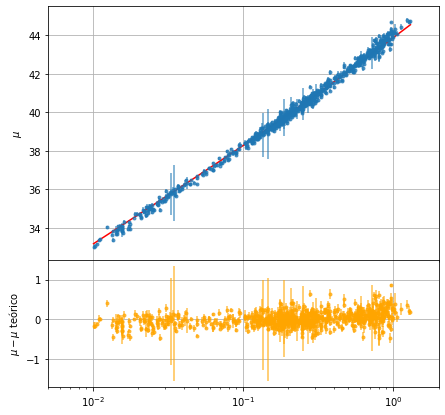

In [78]:
w = [0.1, 3, -19, 0.5]

m = mu(w)
mt = mu_teorico(w)
grafica(x, m, mt, error)

In [79]:
def chi(w):
    m = mu(w)
    mt = mu_teorico(w)
    return abs(np.matmul(np.matmul((m-mt).T, matrix_inv),(m-mt)))

parametro = [0.1, 3, -19, 0.5]
chi(parametro)

#resultado = mini(chi, parametro)

3526436.6446742117

In [46]:
a = minimize(chi, parametro, bounds=((0,1),(2, 4), (-20, -18), (0, 1)))

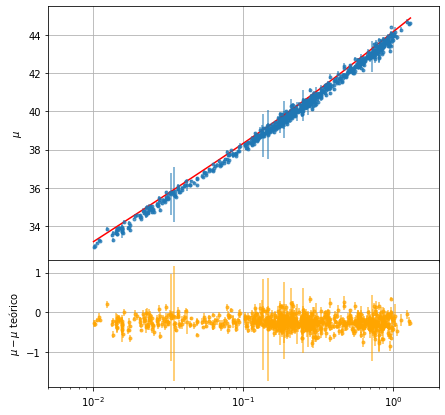

In [80]:
w = a["x"]
m = mu(w)
mt = mu_teorico(w)
grafica(x, m, mt, error)

In [81]:
print(a)

      fun: 3113607.689072732
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.46800482,  0.18626451,  4.47034836,  0.6519258 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 100
      nit: 17
   status: 0
  success: True
        x: array([  0.11412237,   2.54078424, -18.86626044,   0.25365388])
